In [1]:
%matplotlib inline

In [2]:
import csv
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np


def get_feature_labels(file_name):
    with open(file_name, 'r+') as f:
        reader = csv.reader(f)
        next(reader, None)
        features = []
        labels = []
        ignore = ['0', '#N/A', 7, 9]
        lengths = set()
        for row in reader:
            if row[-1] in ignore or int(row[-1]) > 3:
                continue
            str_features = row[1:-1]
            l = row[-1]
            feature_entry = []
            for feat in str_features:
                try:
                    feature_entry.append(float(feat))
                except:
                    feature_entry.append(-1.0)
            l = int(l)
            lengths.add(len(feature_entry))
            classes = [0, 0, 0]
            classes[l-1] = 1
            labels.append(classes)
            features.append(feature_entry)
    return features, labels


f, l = get_feature_labels('./Dataset_v3.csv')

feat_train, feat_test, label_train, label_test = train_test_split(f, l,
                                              test_size=0.5, random_state=42)
model = Sequential()
model.add(Dense(64, input_dim=9, init='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                   metrics=['accuracy', 'precision', 'recall'])

model.fit(feat_train, label_train, nb_epoch=10, batch_size=32, verbose=False)
print(model.evaluate(feat_test, label_test, batch_size=32, verbose=False))


# to supress common keras error
import gc
gc.collect()


Using TensorFlow backend.


[0.13765004177638102, 0.96111036207573763, 0.94226517238310092, 0.94098959037447616]


0

 # Interpreting the result
 The first value just represents the loss in the nueral network. The rest are the important values
 
[loss, accuracy, precision, recall]


* Want loss as low as possible
 
 

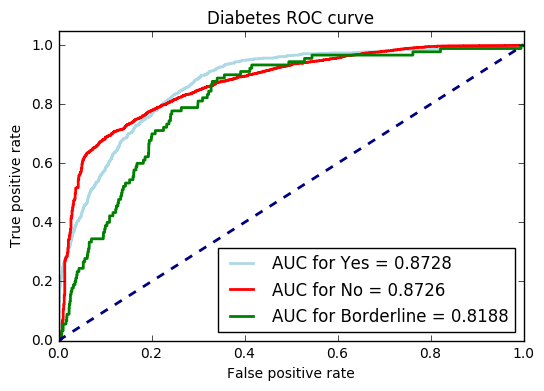

In [3]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Activation
from keras.optimizers import SGD
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, \
    recall_score
from binet_keras import get_tf_model


def plot_roc_curve(feat_train, feat_test, label_train, label_test):
    # calculating the scores
    classifier = get_tf_model(dimension=9, out=3)
    classifier.fit(feat_train, label_train, nb_epoch=10, batch_size=32,
                  verbose=False)
    y_score = classifier.predict_proba(feat_test, batch_size=32, verbose=0)
    label_test = np.array(label_test)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting
    plt.figure()
    lw = 2
    colors = ['lightblue', 'red', 'green']
    lab = ['Yes', 'No', 'Borderline']
    for i in range(3):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=lw,
                 label='AUC for {0} = {1:.4f}'.format(lab[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title("Diabetes ROC curve")
    plt.legend(loc='lower right')
    plt.show()


plot_roc_curve(feat_train, feat_test, label_train, label_test)

In [9]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
# These are the tuned paramters


def decision_tree(feat_train, feat_test, label_train, label_test):
    clf = tree.DecisionTreeClassifier(class_weight=None,
                                      criterion='gini', splitter='best')
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    return result['accuracy'], result['precision'], result['recall']


def random_forest(feat_train, feat_test, label_train, label_test):
    clf = RandomForestClassifier(n_estimators=50)

    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    return result['accuracy'], result['precision'], result['recall']

print("Random forest")
print(random_forest(feat_train, feat_test, label_train, label_test))
print('Decision Tree')
print(decision_tree(feat_train, feat_test, label_train, label_test))

Random forest
(0.94024604569420034, 0.92977678588122925, 0.94024604569420034)
Decision Tree
(0.91611464107070439, 0.9200384944232286, 0.91611464107070439)


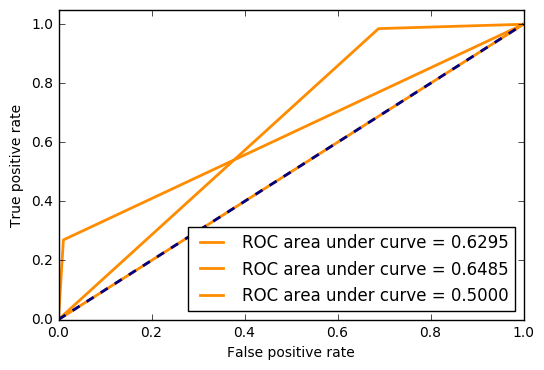

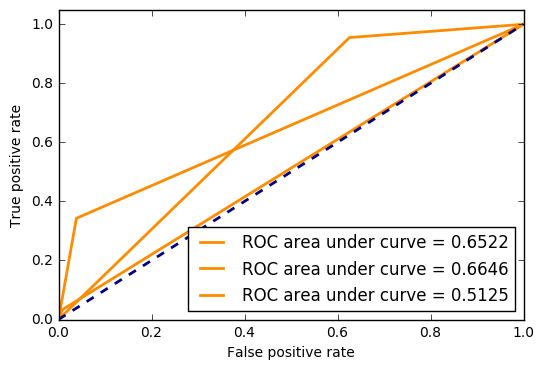

In [12]:

def plot_roc_curve_with(feat_train, feat_test, label_train, label_test, classifier):
    # calculating the scores
    # ytrain = label_binarize(label_train, classes=[0, 1, 2])
    classifier.fit(feat_train, label_train)
    y_score = classifier.predict(feat_test)

    label_test = np.array(label_test)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting
    plt.figure()
    lw = 2
    for i in range(3):
        plt.plot(fpr[i], tpr[i], color='darkorange', lw=lw,
                 label='ROC area under curve = {0:.4f}'.format(roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve_with(feat_train, feat_test, label_train, label_test, RandomForestClassifier(n_estimators=50))
plot_roc_curve_with(feat_train, feat_test, label_train, label_test, tree.DecisionTreeClassifier(class_weight=None,
                                      criterion='gini', splitter='best'))